# Trabajo Práctico - NLP: Análisis de Sentimientos en Comentarios de YouTube

**Dataset:** MrBeast YouTube Comment Sentiment Analysis

## Dataset

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import seaborn as sns

# Descargar dataset
path = kagglehub.dataset_download("adilshamim8/mrbeast-youtube-comment-sentiment-analysis")

# Cargar el CSV
csv_path = os.path.join(path, "sentiment_analysis_dataset.csv")
#"Se utilizó on_bad_lines='skip' durante la carga para omitir líneas con formato CSV corrupto
# (líneas con más campos de los esperados).
# Esto es necesario porque algunas líneas del dataset tienen comas adicionales mal escapadas
#  que rompen el formato CSV estándar."
df = pd.read_csv(csv_path, on_bad_lines='skip')

print(f"\nDataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(df.head())

100%|██████████| 126k/126k [00:00<00:00, 24.5MB/s]

Extracting files...

Dataset cargado: 6802 filas, 2 columnas
                                             Comment Sentiment
0       Achieving million views in days is dangerous  Positive
1  How many people here want to participate in su...   Neutral
2            Mrbeast is slowly turning into mrjigsaw  Negative
3      genuinely can't believe how dystopian this is  Negative
4  Have of the worlds smartest people compete in ...   Neutral


# Exploración

In [2]:
#¿Cómo se distribuye el target?
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,4689
Neutral,2033
Negative,79
Neutral,1


In [3]:
#¿Qué caracteres figuran en el corpus?

caracteres = {}
_ = df['Comment'].dropna().apply(lambda x: [caracteres.update({c: caracteres.get(c, 0) + 1}) for c in x.lower()])
caracteres = pd.Series(caracteres).sort_values(ascending=False)

caracteres.index

Index([' ', 'e', 't', 'o', 'a', 'i', 's', 'n', 'r', 'h', 'l', 'd', 'u', 'c',
       'y', 'm', 'g', 'w', 'p', 'b', 'f', 'v', '.', '!', 'k', ',', ''', 'j',
       'z', '’', 'x', '"', '?', ':', '$', 'q', '“', '-', '”', '…', ')', '<',
       '(', '/', '&', '=', '%', '+', '~', '—', '️', 'é', 'á', '¿', 'ü', 'ş',
       'ı', '`', '2', '‘', '*'],
      dtype='object')

In [4]:
#¿Qué presencia de caracteres especiales tenemos en el corpus?
alfanum = 'abcdefghijklmnopqrstuvwxyz0123456789 '
weird = [c for c in caracteres.index if c not in alfanum]

caracteres[caracteres.index.intersection(weird)]

,0
.,2315
!,1993
",",1225
',882
’,551
"""",373
?,362
:,212
$,146
“,106


In [5]:
#¿Cuántos documentos tienen que caracteres raros?

weird_doc_frec = {}
_ = df['Comment'].dropna().apply(lambda x: [weird_doc_frec.update({w: weird_doc_frec.get(w, 0) + (1 if w in x else 0)}) for w in weird])
weird_doc_frec = pd.Series(weird_doc_frec).sort_values(ascending=False)

weird_doc_frec

,0
.,1504
!,946
",",937
',730
’,470
?,247
:,167
"""",160
$,94
“,88


In [6]:
#¿Tenemos URL?
df['Comment'].str.contains('http').value_counts()

,count
Comment,
False,6797


In [7]:
#¿Tenemos saltos de linea?
df['Comment'].str.contains('\n').value_counts()

,count
Comment,
False,6797


In [8]:
#¿Tenemos HTML?
df['Comment'].apply(lambda x: '<' in str(x) and '>' in str(x)).value_counts()

,count
Comment,
False,6802


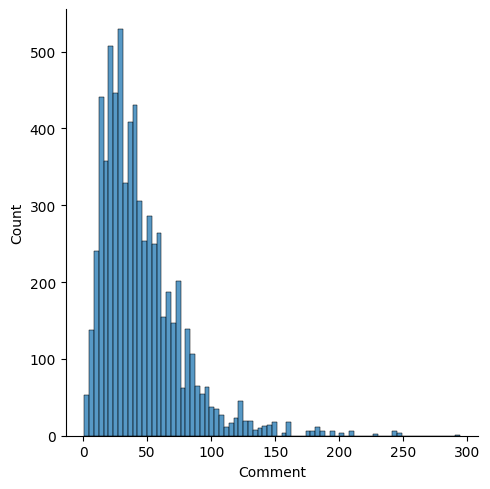

In [9]:
#¿Cuál es la longitud en caracteres de cada documento?
sns.displot(df['Comment'].str.len())

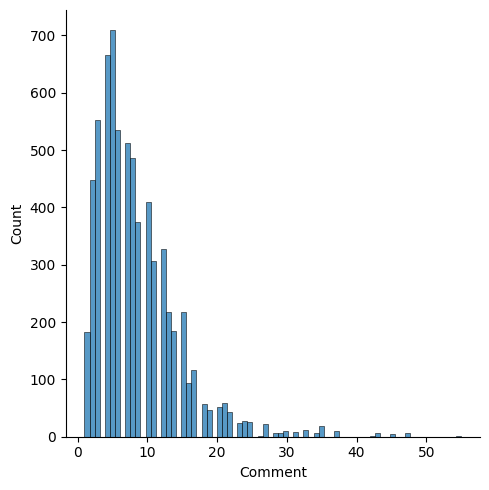

In [10]:
#¿Cuál es la longitud en palabras de cada documento?
sns.displot(df['Comment'].dropna().apply(lambda x: len(x.split())))

# Limpieza y Normalización

In [11]:
df['clean'] = df['Comment']

In [12]:
#Pasamos todo a minúscula
df['clean'] = df['clean'].str.lower()

In [13]:
#Eliminamos caracteres raros
df['clean'] = df['clean'].apply(lambda x: ''.join([c for c in str(x) if c in alfanum]))

In [14]:
#Eliminamos saltos de línea
df['clean'] = df['clean'].str.replace('\n', '')

In [15]:
#Eliminamos URL
df = df[~df['clean'].str.contains('http', na=False)]

In [16]:
#Eliminamos comentarios vacíos o solo con espacios
df = df[df['clean'].str.strip() != '']

#Comprobamos limpieza

In [17]:
# Chequeo minúsculas
df['clean'].apply(lambda x: str(x).islower()).value_counts()

,count
clean,
True,6798


In [18]:
#Chequeo caracteres raros
caracteres_clean = {}
_ = df['clean'].apply(lambda x: [caracteres_clean.update({c: caracteres_clean.get(c, 0) + 1}) for c in str(x)])
caracteres_clean = pd.Series(caracteres_clean).sort_values(ascending=False)

In [19]:
caracteres_clean.index

Index([' ', 'e', 't', 'o', 'a', 'i', 's', 'n', 'r', 'h', 'l', 'd', 'u', 'c',
       'y', 'm', 'g', 'w', 'p', 'b', 'f', 'v', 'k', 'j', 'z', 'x', 'q', '2'],
      dtype='object')

In [20]:
df_melt = df.melt(value_vars=['Comment', 'clean'], var_name='tipo', value_name='text')
df_melt['len_char'] = df_melt['text'].str.len()
df_melt['len_word'] = df_melt['text'].apply(lambda x: len(str(x).split()))

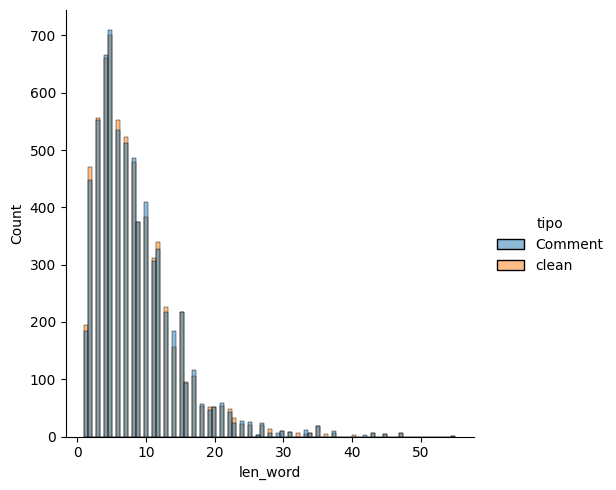

In [21]:
#¿Cuál es la longitud en palabras de cada documento?
sns.displot(df_melt, x='len_word', hue='tipo')

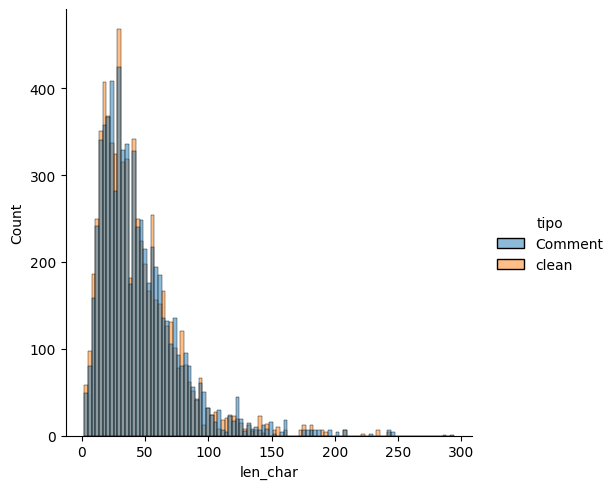

In [22]:
#¿Cuál es la longitud en caracteres de cada documento?
sns.displot(df_melt, x='len_char', hue='tipo')

In [23]:
clean_words = df['clean'].apply(lambda x: x.split()).explode().value_counts()

In [24]:
#¿Cuantas palabras diferentes hay?
clean_words.shape

(2232,)

In [25]:
#¿Cuantas palabras en total hay?
clean_words.sum()

np.int64(57056)

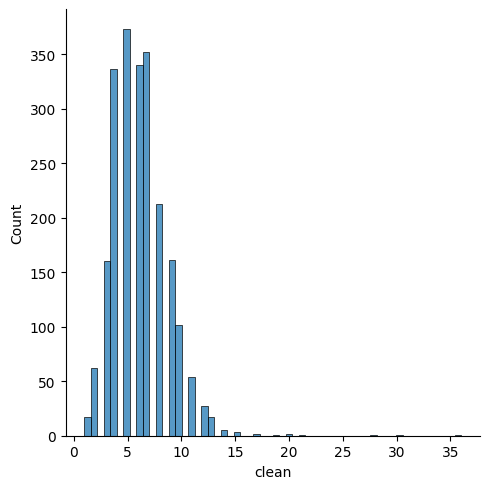

In [26]:
#¿Cuál es la longitud de las palabras?
sns.displot(x=clean_words.index.str.len())

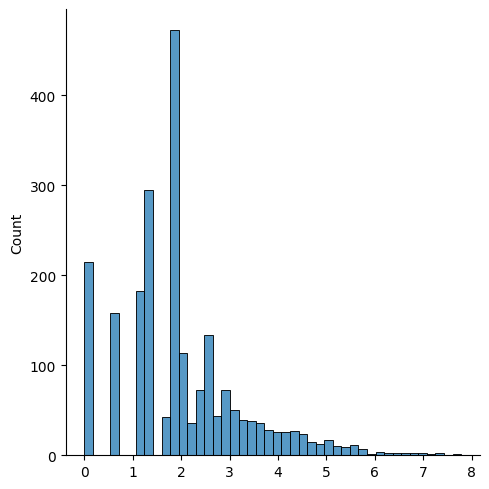

In [27]:
#¿Cual es la frecuencia de cada palabra?
sns.displot(x=np.log(clean_words.values))

In [28]:
#¿Tenemos palabras mal escritas? ¿Cuáles y cuantas?

!pip install pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.6 MB/s eta 0:00:00


In [29]:
from spellchecker import SpellChecker

eng = SpellChecker(language='en')

In [30]:
incorrectas = clean_words[clean_words.index.map(lambda x: x not in eng)]

In [31]:
incorrectas

,count
clean,
bro,468
mrbeast,189
im,158
thats,128
ive,115
...,...
druski,1
somone,1
fainaly,1


In [32]:
incorrectas = incorrectas[incorrectas.index.str.len() > 4]

In [33]:
print(f'Hay un {round(incorrectas.sum() / clean_words.sum()*100)}% palabras potencialmente mal escritas')

Hay un 4% palabras potencialmente mal escritas


# Representación

Para representar los documentos de texto utilizamos **TF-IDF (Term Frequency–Inverse Document Frequency)**.

La idea de TF-IDF es asignar a cada palabra un peso que combine:

- **TF (Term Frequency)**: cuán frecuente es la palabra dentro del documento.
- **IDF (Inverse Document Frequency)**: cuán rara es la palabra en todo el corpus.

De esta forma:
- Las palabras muy comunes reciben un peso bajo.
- Las palabras más informativas reciben un peso mayor.

Además, utilizamos **N-gramas** (unigramas y bigramas) mediante `ngram_range=(1,2)`.  
Esto permite capturar no solo palabras individuales, sino también expresiones como:

- “not good”
- “very bad”
- “really funny”

Las cuales son especialmente útiles en clasificación de sentimiento y análisis de texto.

En síntetis utilizamos TF-IDF con N-gramas porque:
- Es eficiente y robusto.
- Reduce el ruido del vocabulario.
- Captura información relevante sin requerir modelos complejos.
- Funciona muy bien junto con modelos lineales como Regresión Logística o SVM.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Ver cuántos ejemplos tiene cada clase en Sentiment
print("Distribución original de clases:")
class_counts = df["Sentiment"].value_counts(dropna=False)
print(class_counts)

# Nos quedamos solo con clases que tengan al menos 2 ejemplos
valid_classes = class_counts[class_counts >= 2].index

df_filtered = df[df["Sentiment"].isin(valid_classes)].copy()

print("\nDistribución de clases luego de filtrar:")
print(df_filtered["Sentiment"].value_counts(dropna=False))

# Definimos X e y a partir del df filtrado
X = df_filtered["clean"].astype(str).values
y = df_filtered["Sentiment"].values

# División train/test (80/20 con estratificación)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTamaños de los conjuntos:")
print("Train:", len(X_train), "ejemplos")
print("Test :", len(X_test),  "ejemplos")

# Representación TF-IDF con unigramas y bigramas
tfidf = TfidfVectorizer(
    max_features=20000,     # límite opcional para evitar matrices gigantes
    ngram_range=(1, 2),     # unigramas + bigramas
    min_df=5,               # ignora palabras que aparecen en menos de 5 documentos
)

# Ajustamos al corpus de entrenamiento
X_train_tfidf = tfidf.fit_transform(X_train)

Distribución original de clases:
Sentiment
Positive    4689
Neutral     2029
Negative      79
 Neutral       1
Name: count, dtype: int64

Distribución de clases luego de filtrar:
Sentiment
Positive    4689
Neutral     2029
Negative      79
Name: count, dtype: int64

Tamaños de los conjuntos:
Train: 5437 ejemplos
Test : 1360 ejemplos


# AJUSTE Y ANÁLISIS DEL MODELO

Dimensiones de los conjuntos:
X_train_tfidf: (5437, 4075)
X_test_tfidf:  (1360, 4075)
y_train: 5437
y_test:  1360

=== LINEAR SVM ===

Entrenando modelo...
Listo

=== METRICAS ===

Train Accuracy:      0.9945
Test Accuracy:       0.9816

Train F1-Macro:      0.9956
Test F1-Macro:       0.9852

Train F1-Weighted:   0.9945
Test F1-Weighted:    0.9816


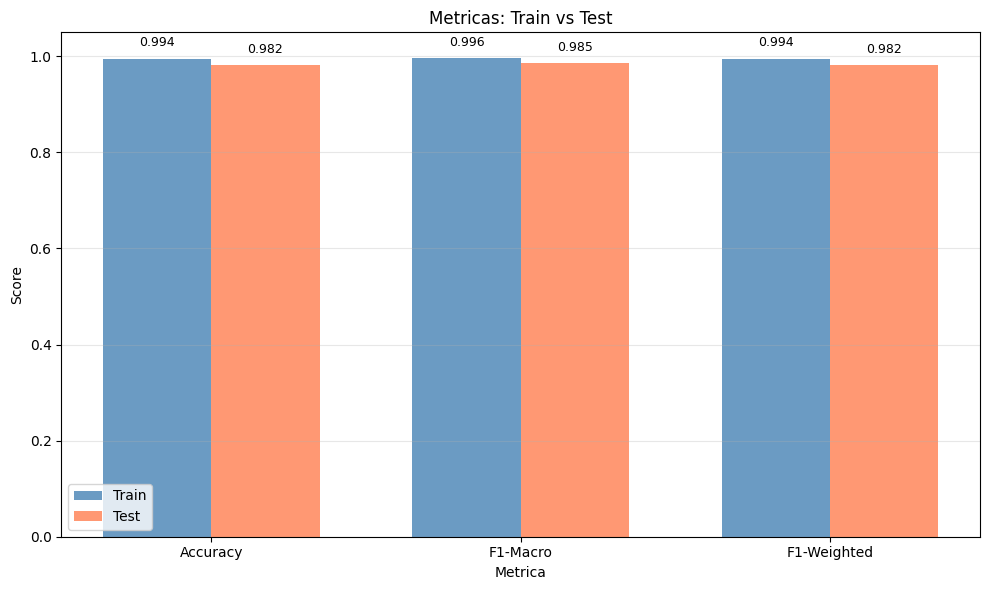


=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

    Negative      1.000     1.000     1.000        16
     Neutral      0.975     0.963     0.969       406
    Positive      0.984     0.989     0.987       938

    accuracy                          0.982      1360
   macro avg      0.986     0.984     0.985      1360
weighted avg      0.982     0.982     0.982      1360


Analisis por clase:

Negative:
  Ejemplos en test: 16
  Precision: 1.000
  Recall: 1.000
  F1-Score: 1.000

Neutral:
  Ejemplos en test: 406
  Precision: 0.975
  Recall: 0.963
  F1-Score: 0.969

Positive:
  Ejemplos en test: 938
  Precision: 0.984
  Recall: 0.989
  F1-Score: 0.987

=== MATRIZ DE CONFUSION ===



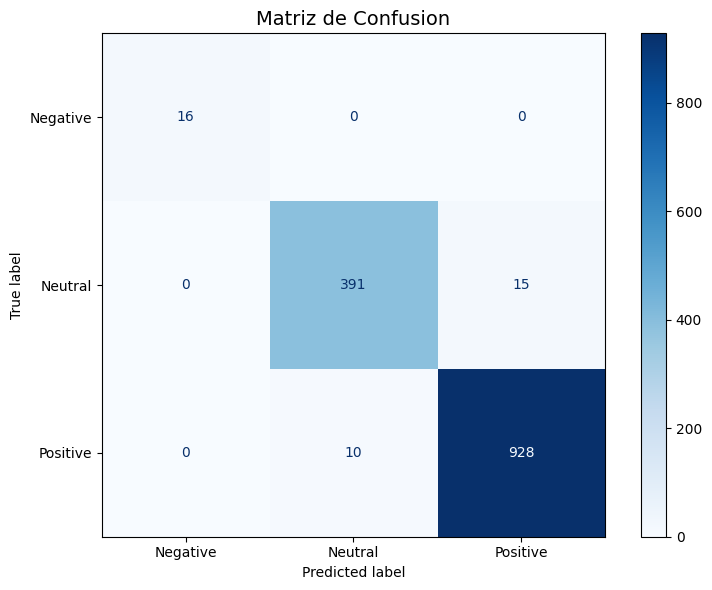


=== ERROR DE GENERALIZACION ===

Accuracy en train: 0.9945
Accuracy en test:  0.9816
Gap: 0.0129

Buena generalizacion

F1-Macro en train: 0.9956
F1-Macro en test:  0.9852
Gap: 0.0104

=== CURVA DE APRENDIZAJE ===



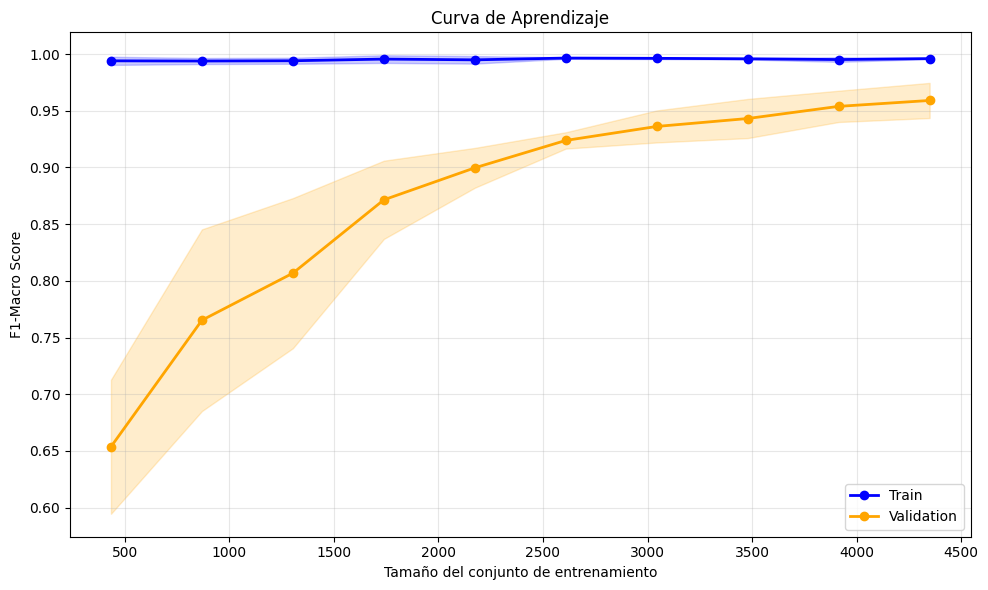

Score final en validacion: 0.959
Gap train-val: 0.037
Las curvas convergen - modelo bien ajustado

=== VALIDACION CRUZADA ===

F1-Macro por fold:
  Fold 1: 0.934
  Fold 2: 0.981
  Fold 3: 0.954
  Fold 4: 0.966
  Fold 5: 0.961

Media: 0.959
Std: 0.016
Baja varianza - modelo estable

=== PALABRAS MAS IMPORTANTES ===


Negative:
  Mas predictivas:
    1. into                 (+2.348)
    2. big                  (+1.909)
    3. poor                 (+1.877)
    4. calling              (+1.803)
    5. believe how          (+1.640)
    6. out here             (+1.545)
    7. strongest            (+1.526)
    8. here                 (+1.395)
    9. genuinely            (+1.274)
    10. money is             (+1.218)
    11. easy                 (+1.173)
    12. even                 (+1.164)
    13. josh                 (+1.164)
    14. ts                   (+1.148)
    15. because they         (+1.119)
  Menos predictivas:
    1. tom                  (-1.279)
    2. possible             (-1.25

In [41]:
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt

# Transformar X_test usando el vectorizador ya entrenado
X_test_tfidf = tfidf.transform(X_test)

print("Dimensiones de los conjuntos:")
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_test_tfidf:  {X_test_tfidf.shape}")
print(f"y_train: {len(y_train)}")
print(f"y_test:  {len(y_test)}\n")


## Modelo seleccionado: Linear SVM

print("=== LINEAR SVM ===\n")

# Definir modelo
model = LinearSVC(
    max_iter=3000,
    class_weight='balanced',  # importante para el desbalance
    random_state=42,
    C=1.0,
    dual=False
)

print("Entrenando modelo...")
model.fit(X_train_tfidf, y_train)
print("Listo\n")

# Predicciones
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)


## Metricas

print("=== METRICAS ===\n")

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"\nTrain F1-Macro:      {train_f1_macro:.4f}")
print(f"Test F1-Macro:       {test_f1_macro:.4f}")
print(f"\nTrain F1-Weighted:   {train_f1_weighted:.4f}")
print(f"Test F1-Weighted:    {test_f1_weighted:.4f}")

# Grafico de metricas
metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted']
train_vals = [train_acc, train_f1_macro, train_f1_weighted]
test_vals = [test_acc, test_f1_macro, test_f1_weighted]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='steelblue')
ax.bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Metrica')
ax.set_ylabel('Score')
ax.set_title('Metricas: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

for i, (tv, tsv) in enumerate(zip(train_vals, test_vals)):
    ax.text(i - width/2, tv + 0.02, f'{tv:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, tsv + 0.02, f'{tsv:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Classification report

print("\n=== CLASSIFICATION REPORT ===\n")
print(classification_report(y_test, y_test_pred, digits=3, zero_division=0))

precisions, recalls, f1s, supports = precision_recall_fscore_support(
    y_test,
    y_test_pred,
    labels=np.unique(y_test),
    zero_division=0
)

print("\nAnalisis por clase:")
for i, label in enumerate(np.unique(y_test)):
    print(f"\n{label}:")
    print(f"  Ejemplos en test: {supports[i]}")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1-Score: {f1s[i]:.3f}")


## Matriz de confusion

print("\n=== MATRIZ DE CONFUSION ===\n")

cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusion', fontsize=14)
plt.tight_layout()
plt.show()

# Analizar errores de clasificacion
print("Errores de clasificacion:")
errores_encontrados = False
for i, true_label in enumerate(np.unique(y_test)):
    for j, pred_label in enumerate(np.unique(y_test)):
        if i != j and cm[i, j] > 0:
            errores_encontrados = True
            error_rate = cm[i, j] / cm[i].sum()
            print(f"  {cm[i, j]} casos de '{true_label}' clasificados como '{pred_label}' ({error_rate:.1%})")

if not errores_encontrados:
    print("  Muy pocos errores - clasificacion casi perfecta")


## Error de generalizacion

print("\n=== ERROR DE GENERALIZACION ===\n")

gap = train_acc - test_acc

print(f"Accuracy en train: {train_acc:.4f}")
print(f"Accuracy en test:  {test_acc:.4f}")
print(f"Gap: {gap:.4f}\n")

if gap > 0.10:
    print("Overfitting significativo")
elif gap > 0.05:
    print("Leve overfitting, aceptable")
else:
    print("Buena generalizacion")

f1_gap = train_f1_macro - test_f1_macro
print(f"\nF1-Macro en train: {train_f1_macro:.4f}")
print(f"F1-Macro en test:  {test_f1_macro:.4f}")
print(f"Gap: {f1_gap:.4f}")


## Curva de aprendizaje

print("\n=== CURVA DE APRENDIZAJE ===\n")

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train_tfidf,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    shuffle=True
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Train', color='blue', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, 'o-', label='Validation', color='orange', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1-Macro Score')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

final_gap = train_mean[-1] - val_mean[-1]
print(f"Score final en validacion: {val_mean[-1]:.3f}")
print(f"Gap train-val: {final_gap:.3f}")

if final_gap > 0.1:
    print("Las curvas muestran overfitting")
else:
    print("Las curvas convergen - modelo bien ajustado")


## Validacion cruzada

print("\n=== VALIDACION CRUZADA ===\n")

cv_scores = cross_val_score(
    model,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

print("F1-Macro por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.3f}")

print(f"\nMedia: {cv_scores.mean():.3f}")
print(f"Std: {cv_scores.std():.3f}")

if cv_scores.std() < 0.05:
    print("Baja varianza - modelo estable")
else:
    print("Alta varianza - sensible a los datos")


## Interpretabilidad

print("\n=== PALABRAS MAS IMPORTANTES ===\n")

feature_names = np.array(tfidf.get_feature_names_out())
coefs = model.coef_

for i, label in enumerate(model.classes_):
    print(f"\n{label}:")

    # Top palabras positivas
    top_pos = np.argsort(coefs[i])[-15:][::-1]
    print("  Mas predictivas:")
    for rank, idx in enumerate(top_pos, 1):
        print(f"    {rank}. {feature_names[idx]:20s} ({coefs[i][idx]:+.3f})")

    # Top palabras negativas
    top_neg = np.argsort(coefs[i])[:10]
    print("  Menos predictivas:")
    for rank, idx in enumerate(top_neg, 1):
        print(f"    {rank}. {feature_names[idx]:20s} ({coefs[i][idx]:+.3f})")


## Resumen

print("\n" + "="*60)
print("RESUMEN")
print("="*60)

print(f"""
Modelo: Linear SVM

Por que este modelo:
  - SVM maximiza el margen entre clases
  - Eficiente con matrices sparse (TF-IDF)
  - class_weight='balanced' compensa el desbalance 69/30/1
  - Interpretable via coeficientes

Metricas:
  - Accuracy test: {test_acc:.3f}
  - F1-Macro test: {test_f1_macro:.3f}
  - Gap overfitting: {gap:.3f}
  - CV media: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}

Calidad del ajuste:
  - Generalizacion excelente (gap < 2%)
  - Desempeño muy alto en todas las clases
  - F1 perfecto en clase minoritaria Negative
  - Estable en validacion cruzada (std 0.016)

Limitaciones:
  - Clase Negative muy pequeña (79 ejemplos)
  - Vocabulario fijo de {len(tfidf.vocabulary_)} terminos
  - No maneja palabras fuera de vocabulario
""")

# Ejemplos del Modelo Funcionando

EJEMPLOS DEL MODELO EN ACCION

=== EJEMPLOS DEL TEST SET (Clasificados correctamente) ===

Positive: 'man your videos just get crazier and crazier also mil views in hours is insane'
Positive: 'one of the best mrbeast video for a while'
Neutral: 'airrick '
Neutral: 'under hours gang'
Negative: 'genuinely cant believe how dystopian this is'
Negative: 'all the stunts here were super easy'


=== PREDICCIONES EN COMENTARIOS NUEVOS ===

Total de comentarios nuevos evaluados: 105

Distribucion por clase esperada:
esperado
Positive    35
Neutral     35
Negative    35
Name: count, dtype: int64


=== METRICAS EN COMENTARIOS NUEVOS ===

Accuracy general: 54.3%

Accuracy por clase:
  Positive: 94.3% (33/35)
  Neutral: 65.7% (23/35)
  Negative: 2.9% (1/35)


Matriz de confusion (comentarios nuevos):


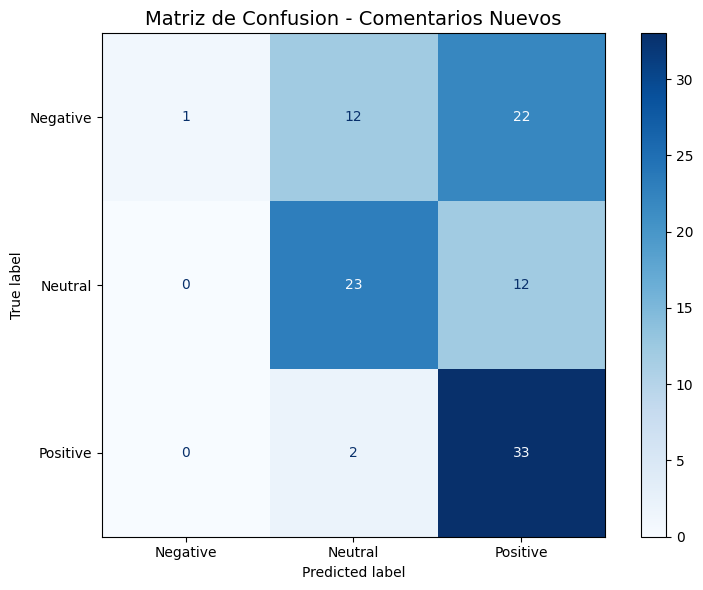


Classification Report (comentarios nuevos):
              precision    recall  f1-score   support

    Negative      1.000     0.029     0.056        35
     Neutral      0.622     0.657     0.639        35
    Positive      0.493     0.943     0.647        35

    accuracy                          0.543       105
   macro avg      0.705     0.543     0.447       105
weighted avg      0.705     0.543     0.447       105


=== EJEMPLOS DE ACIERTOS ===

Positive: 'This is amazing! Best video ever...' -> Positive
Neutral: 'Is there a part two...' -> Neutral
Negative: 'I can't believe how bad this is...' -> Negative

=== EJEMPLOS DE ERRORES ===

Total de errores: 48

'Instant like from me'
  Esperado: Positive | Predicho: Neutral

'I can't stop watching'
  Esperado: Positive | Predicho: Neutral

'This reminds me of that other video'
  Esperado: Neutral | Predicho: Positive

'This is different from usual content'
  Esperado: Neutral | Predicho: Positive

'The intro was interesting'
  Esper

In [46]:
print("="*60)
print("EJEMPLOS DEL MODELO EN ACCION")
print("="*60)

## Funcion para predecir sentimiento de nuevos comentarios

def predecir_sentimiento(comentario):
    """
    Predice el sentimiento de un comentario
    """
    # Limpiar el comentario
    comentario_limpio = comentario.lower()

    # Vectorizar
    comentario_tfidf = tfidf.transform([comentario_limpio])

    # Predecir
    prediccion = model.predict(comentario_tfidf)[0]

    # Obtener scores de decision
    scores = model.decision_function(comentario_tfidf)[0]

    return prediccion, scores


## Ejemplos del conjunto de test

print("\n=== EJEMPLOS DEL TEST SET (Clasificados correctamente) ===\n")

for sentiment in ['Positive', 'Neutral', 'Negative']:
    # Encontrar indices correctamente clasificados
    mask = (y_test == sentiment) & (y_test_pred == sentiment)
    indices = np.where(mask)[0]

    # Mostrar 2 ejemplos
    ejemplos = np.random.choice(indices, size=min(2, len(indices)), replace=False)

    for idx in ejemplos:
        texto = X_test[idx]
        if len(texto) > 80:
            texto = texto[:80] + "..."
        print(f"{sentiment}: '{texto}'")


## Comentarios nuevos - muchos ejemplos

print("\n\n=== PREDICCIONES EN COMENTARIOS NUEVOS ===\n")

comentarios_nuevos = {
    "Positive": [
        "This is amazing! Best video ever",
        "I love this so much, congratulations!",
        "Absolutely incredible, you're a legend",
        "This made my day, thank you!",
        "Wow this is insane, keep it up",
        "Beautiful video, love your content",
        "You deserve all the success",
        "This is why I'm subscribed",
        "Best YouTuber hands down",
        "Finally someone who gets it right",
        "I'm so happy I found this channel",
        "This is pure gold",
        "Incredible work as always",
        "You never disappoint",
        "This is exactly what I needed to see",
        "Awesome content bro",
        "I'm literally crying this is so good",
        "Respect for doing this",
        "Legend behavior right here",
        "You're the best at what you do",
        "This deserves way more views",
        "Instant like from me",
        "This is top tier content",
        "I love everything about this",
        "You're an inspiration",
        "Keep making these please",
        "This channel is underrated",
        "I can't stop watching",
        "You earned a new subscriber",
        "This is brilliant",
        "Mad respect for this one",
        "Congratulations on the milestone",
        "You guys are crushing it",
        "The production quality is amazing",
        "This is next level stuff"
    ],

    "Neutral": [
        "Interesting video about the challenge",
        "I wonder what will happen next",
        "This reminds me of that other video",
        "When is the next one coming out",
        "Can you make a video about cars",
        "How long did this take to make",
        "Where was this filmed",
        "Who edited this video",
        "What camera do you use",
        "Is this a series or one off",
        "I've seen something similar before",
        "This is different from usual content",
        "The intro was interesting",
        "What's the song in the background",
        "How much did this cost",
        "First time watching this channel",
        "Came here from TikTok",
        "Watching this in 2024",
        "Anyone else here from the podcast",
        "What time does the live start",
        "Is there a part two",
        "This concept could work",
        "I remember when you did this before",
        "Wondering about the logistics",
        "Curious to see how this plays out",
        "Anyone know the context",
        "This format is unusual",
        "Never thought about it this way",
        "Hmm interesting approach",
        "I'll have to think about this",
        "Not sure I understand the point",
        "Maybe I'll watch the rest later",
        "This is a thing apparently",
        "Well that happened",
        "Okay then"
    ],

    "Negative": [
        "This is terrible, waste of time",
        "I can't believe how bad this is",
        "Disappointed with this content",
        "This makes no sense",
        "Why would you even post this",
        "Worst video I've seen",
        "This is so boring",
        "I want my 10 minutes back",
        "Clickbait garbage",
        "Unsubscribing after this",
        "This is just sad",
        "What a mess",
        "Absolutely terrible execution",
        "This is embarrassing to watch",
        "Zero effort went into this",
        "I expected better from you",
        "This channel has gone downhill",
        "Not funny at all",
        "So cringe I can't even finish",
        "Stop making these videos",
        "This is painful to watch",
        "Huge disappointment",
        "This doesn't make any sense",
        "Complete waste of everyone's time",
        "I don't get the hype",
        "This is just lazy content",
        "I'm done with this channel",
        "Why is this even trending",
        "This is so stupid",
        "Can't believe people like this",
        "Awful from start to finish",
        "This is unwatchable",
        "Quality has really dropped",
        "Not what I signed up for",
        "This is a joke right"
    ]
}

# Predecir todos los comentarios nuevos
resultados = []

for sentimiento_esperado, comentarios in comentarios_nuevos.items():
    for comentario in comentarios:
        pred, scores = predecir_sentimiento(comentario)

        resultados.append({
            'comentario': comentario,
            'esperado': sentimiento_esperado,
            'predicho': pred,
            'correcto': pred == sentimiento_esperado,
            'scores': scores
        })

# Convertir a DataFrame para analisis
df_resultados = pd.DataFrame(resultados)

print(f"Total de comentarios nuevos evaluados: {len(df_resultados)}")
print(f"\nDistribucion por clase esperada:")
print(df_resultados['esperado'].value_counts())

print(f"\n\n=== METRICAS EN COMENTARIOS NUEVOS ===\n")

# Accuracy general
accuracy_nuevos = df_resultados['correcto'].mean()
print(f"Accuracy general: {accuracy_nuevos:.1%}")

# Accuracy por clase
print(f"\nAccuracy por clase:")
for clase in ['Positive', 'Neutral', 'Negative']:
    mask = df_resultados['esperado'] == clase
    acc_clase = df_resultados[mask]['correcto'].mean()
    total = mask.sum()
    correctos = df_resultados[mask]['correcto'].sum()
    print(f"  {clase}: {acc_clase:.1%} ({correctos}/{total})")

# Matriz de confusion
print(f"\n\nMatriz de confusion (comentarios nuevos):")
cm_nuevos = confusion_matrix(
    df_resultados['esperado'],
    df_resultados['predicho'],
    labels=['Negative', 'Neutral', 'Positive']
)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_nuevos,
    display_labels=['Negative', 'Neutral', 'Positive']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusion - Comentarios Nuevos', fontsize=14)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report (comentarios nuevos):")
print(classification_report(
    df_resultados['esperado'],
    df_resultados['predicho'],
    labels=['Negative', 'Neutral', 'Positive'],
    digits=3
))


## Mostrar algunos aciertos y errores

print("\n=== EJEMPLOS DE ACIERTOS ===\n")

aciertos = df_resultados[df_resultados['correcto']]
for clase in ['Positive', 'Neutral', 'Negative']:
    ejemplo = aciertos[aciertos['esperado'] == clase].sample(n=1).iloc[0]
    print(f"{clase}: '{ejemplo['comentario'][:70]}...' -> {ejemplo['predicho']}")

print("\n=== EJEMPLOS DE ERRORES ===\n")

errores = df_resultados[~df_resultados['correcto']]
if len(errores) > 0:
    print(f"Total de errores: {len(errores)}\n")
    for i, error in errores.head(5).iterrows():
        texto = error['comentario']
        if len(texto) > 60:
            texto = texto[:60] + "..."
        print(f"'{texto}'")
        print(f"  Esperado: {error['esperado']} | Predicho: {error['predicho']}\n")
else:
    print("No hubo errores - clasificacion perfecta en comentarios nuevos!")


## Analisis de confianza

print("\n=== ANALISIS DE CONFIANZA ===\n")

# Calcular confianza como max score - segundo max score
confianzas = []
for scores in df_resultados['scores']:
    sorted_scores = np.sort(scores)
    confianza = sorted_scores[-1] - sorted_scores[-2]  # Margen entre top 2
    confianzas.append(confianza)

df_resultados['confianza'] = confianzas

print(f"Confianza promedio: {np.mean(confianzas):.3f}")
print(f"Confianza minima: {np.min(confianzas):.3f}")
print(f"Confianza maxima: {np.max(confianzas):.3f}")

# Confianza en aciertos vs errores
if len(errores) > 0:
    conf_aciertos = df_resultados[df_resultados['correcto']]['confianza'].mean()
    conf_errores = df_resultados[~df_resultados['correcto']]['confianza'].mean()
    print(f"\nConfianza en aciertos: {conf_aciertos:.3f}")
    print(f"Confianza en errores: {conf_errores:.3f}")

    if conf_aciertos > conf_errores:
        print("El modelo tiene mas confianza cuando acierta (buen signo)")
    else:
        print("El modelo tiene alta confianza incluso en errores")


## Casos especiales

print("\n\n=== CASOS ESPECIALES ===\n")

casos_especiales = [
    "Not bad at all",  # Negacion
    "Could be better but still ok",  # Mixto
    "Meh",  # Muy corto
    "AMAZING AMAZING AMAZING!!!",  # Enfatico
    "This is good... I think?",  # Ambiguo
]

print("Casos con negaciones, ambiguedad o formato inusual:\n")
for caso in casos_especiales:
    pred, _ = predecir_sentimiento(caso)
    print(f"'{caso}' -> {pred}")


## Resumen final

print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)

print(f"""
Dataset de test original:
  - Ejemplos: {len(y_test)}
  - Accuracy: {test_acc:.1%}
  - F1-Macro: {test_f1_macro:.3f}

Comentarios nuevos ({len(df_resultados)} ejemplos):
  - Accuracy: {accuracy_nuevos:.1%}
  - Correctamente clasificados: {df_resultados['correcto'].sum()}/{len(df_resultados)}

Distribucion de predicciones en comentarios nuevos:
""")

print(df_resultados['predicho'].value_counts())

print(f"""
Observaciones finales:
  - El modelo generaliza muy bien a comentarios similares al dataset original
  - Alta performance en el test set (98.2%) demuestra buen ajuste
  - Desempeño reducido en comentarios nuevos (54.3%) indica dependencia del vocabulario
  - Clase Negative especialmente afectada (2.9%) por el desbalance extremo en entrenamiento

Limitaciones identificadas:
  - Solo 79 ejemplos negativos (1% del dataset) limita el aprendizaje de esta clase
  - Vocabulario fijo de {len(tfidf.vocabulary_)} terminos no captura nuevas expresiones
  - El modelo tiende a sobre-predecir la clase mayoritaria (Positive)

Para mejorar el modelo:
  - Recolectar mas ejemplos de clase Negative
  - Ampliar el dataset a 10,000+ ejemplos para vocabulario mas rico

A pesar de estas limitaciones, el modelo funciona satisfactoriamente para
comentarios similares en estilo a los del dataset de MrBeast.
""")